In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets
from sklearn import feature_selection

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

from scipy.stats import kendalltau as kt
from scipy.stats import ttest_rel as tt

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.19 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/2d8c4036bceb477faccd56663cd2cbab

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from shutil import copyfile
import scipy.misc

In [5]:
sns.set(style="white")

## Load Data

In [6]:
path = "data\\sorted\\agg\\ids.csv"
biomarkers_path = "data\\sorted\\biomarkers.xlsx"
root_dir = "data\\sorted\\agg\\"

In [7]:
data = pd.read_csv(path, index_col=0)
data = data[~data['name'].str.contains("_flipped")]

In [8]:
data = data.sample(frac=1)

In [9]:
data.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
48,48,2017.11.17,3600,27.30 s.tifheightmap.mat,8.641901,4628,21899.782263,0.808390,1,0.587235,4.732019,[[4.62800000e+03 2.12694000e+05 1.31068640e+07...,1.337123,318.350288,[[284.66028226 109.82674276]\r\n [109.82674276...,0,1,2.711338,8
35,35,2017.11.17,3600,13.70 s.tifheightmap.mat,4.824366,2156,6328.815055,0.954926,1,0.448606,2.935443,[[2.15600000e+03 1.00601000e+05 5.69279700e+06...,1.025429,236.308658,[[204.69964198 248.2288051 ]\r\n [248.2288051 ...,2,1,1.569720,3
13,13,2017.11.09,3600,chip3_04heightmap.mat,8.268838,1136,4832.504854,0.896216,1,0.780220,4.253966,[[1.13600000e+03 3.06810000e+04 1.06870300e+06...,1.450708,149.597980,[[ 44.53901756 20.42403231]\r\n [ 20.42403231...,0,1,2.171663,2
137,137,2017.11.23,1800,30.40 s.tifheightmap.mat,12.672682,7150,51565.232138,0.762010,1,0.581065,7.211921,[[7.15000000e+03 3.91770000e+05 2.49082840e+07...,0.262741,435.847763,[[1008.79867512 152.90892718]\r\n [ 152.90892...,0,1,4.043328,10
36,36,2017.11.17,3600,13.71 s.tifheightmap.mat,11.271277,2008,10675.380820,0.964827,1,0.713829,5.316425,[[2.00800000e+03 1.09321000e+05 7.30508700e+06...,1.570170,229.053824,[[4.65779938e+01 3.92775015e-01]\r\n [3.927750...,0,1,3.260078,2


In [10]:
donor = data['date']
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [11]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 48 to 60
Data columns (total 13 columns):
flow_rate          201 non-null int64
peak_val           201 non-null float64
area               201 non-null int64
volume             201 non-null float64
eccentricity       201 non-null float64
euler_number       201 non-null int64
extent             201 non-null float64
mean_intensity     201 non-null float64
perimeter          201 non-null float64
cluster            201 non-null int64
num_peaks          201 non-null int64
sd                 201 non-null float64
num_local_peaks    201 non-null int64
dtypes: float64(7), int64(6)
memory usage: 22.0 KB


In [12]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())
df_normalize = preprocessing.Normalizer().fit_transform(samples.as_matrix())
df_raw = samples.as_matrix()

In [13]:
normalized.shape

(201, 12)

## Data Analysis

In [14]:
biomarkers = pd.read_excel(biomarkers_path)
biomarkers = biomarkers.rename(columns=lambda x: x.strip())
biomarkers = biomarkers[biomarkers['Donor']!=1]

In [15]:
biomarkers.head()

,Donor,Sample date measured,FSC-A Median,SCC-A Median,GPVI Geomean,ADAM10 Geomean,AK2 Geomean,CD9 Geomean,CD41 Geomean,RCA - FITC Geomean,...,HGB g/L,HCT L/L,MCV fL,MCH pg,MCHC g/L,RDW %CV,PLT x10^9/L,MPV fL,PLT PRP count 10^9/L,MPV PRP fL
0,Donor 1,2017.11.09,4801,1406,5361.0,505,NaN,36.6,NaN,14010,...,209,0.628,93.8,31.2,333,12.7,73,7.9,495,7.0
1,Donor 2,2017.11.17,8093,1689,3698.0,760,1032.0,38.3,84.2,13555,...,156,0.443,89.0,31.3,352,12.3,232,7.5,444,7.3
2,Donor 3,2017.11.22,5218,1005,2865.0,728,652.0,300.0,493.0,916,...,112,0.338,96.1,31.8,331,12.7,271,7.1,545,7.1
3,Donor 4,2017.11.23,5516,943,NaN,124,697.0,178.0,557.0,1555,...,131,0.381,91.5,31.5,344,12.7,235,7.5,449,7.4


In [16]:
biomarker_values = biomarkers.drop(columns=['Donor','Sample date measured'])

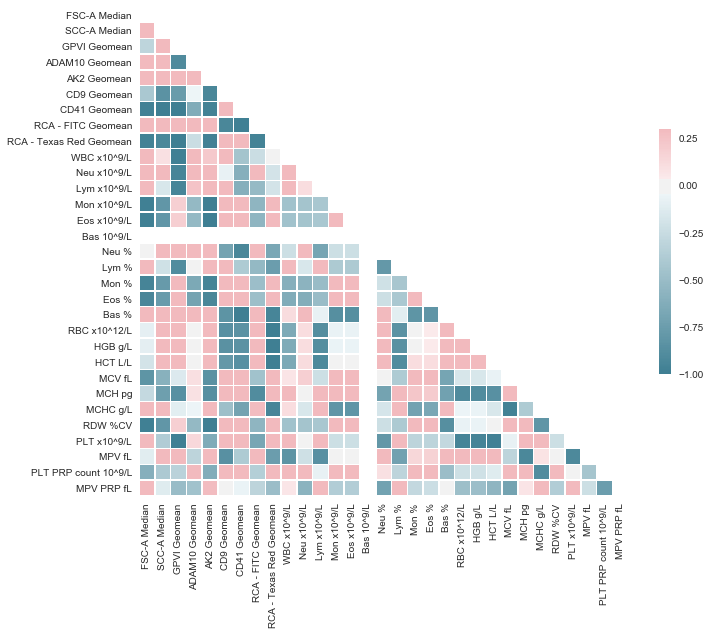

In [17]:
# Compute the correlation matrix
corr = pd.DataFrame(data=biomarker_values,columns=list(biomarker_values)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
biomarkers_ranked = biomarker_values.rank()

biomarkers_merged = []
biomarkers_merged.append([biomarkers_ranked['FSC-A Median']])

for column in biomarkers_ranked:
    found_match = False
    for merged in biomarkers_merged:
        merged_bm = merged[0]
        
        #print(type(merged_bm))
        
        if merged_bm.equals(biomarkers_ranked[column]):
            merged.append(biomarkers_ranked[column])
            found_match = True
            break
    
    if not found_match:
        biomarkers_merged.append([biomarkers_ranked[column]])

for markers in biomarkers_merged:
    marker = markers[0]
    print(marker.values)
    
print(len(biomarkers_merged))

[1. 4. 2. 3.]
[3. 4. 2. 1.]
[ 3.  2.  1. nan]
[2. 4. 3. 1.]
[nan  3.  1.  2.]
[1. 2. 4. 3.]
[nan  1.  2.  3.]
[4. 3. 1. 2.]
[nan  1.  3.  2.]
[1. 3. 4. 2.]
[2.  3.5 3.5 1. ]
[1.  3.5 3.5 2. ]
[3. 1. 3. 3.]
[2.5 2.5 2.5 2.5]
[4. 3. 2. 1.]
[1.  3.5 2.  3.5]
[3. 1. 2. 4.]
[3.  4.  1.5 1.5]
[3. 1. 4. 2.]
[2. 4. 1. 3.]
[4.  2.5 1.  2.5]
[1. 3. 2. 4.]
22


## Visualisation of features:

In [19]:
pd.DataFrame(data=df_raw,columns=list(samples)).corr()

,flow_rate,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,perimeter,cluster,num_peaks,sd,num_local_peaks
flow_rate,1.000000,-0.102240,0.221021,0.131866,0.134623,0.064289,-0.090721,-0.056319,0.203549,0.046442,0.107053,-0.080883,0.168293
peak_val,-0.102240,1.000000,0.280271,0.627473,0.019055,-0.155513,0.032398,0.937255,0.166849,-0.515721,0.053867,0.953946,0.163283
area,0.221021,0.280271,1.000000,0.784723,0.158622,-0.236161,-0.456352,0.264083,0.891434,-0.224668,0.408012,0.209509,0.858900
volume,0.131866,0.627473,0.784723,1.000000,0.142540,-0.198453,-0.243957,0.660254,0.592951,-0.326395,0.280768,0.605037,0.618585
eccentricity,0.134623,0.019055,0.158622,0.142540,1.000000,-0.017693,-0.288395,-0.001788,0.232879,0.132622,0.200394,-0.016226,0.143308
euler_number,0.064289,-0.155513,-0.236161,-0.198453,-0.017693,1.000000,0.049550,-0.171327,-0.207547,0.055974,0.052758,-0.173184,-0.301946
extent,-0.090721,0.032398,-0.456352,-0.243957,-0.288395,0.049550,1.000000,0.111306,-0.614109,-0.187498,-0.594603,0.156808,-0.560055
mean_intensity,-0.056319,0.937255,0.264083,0.660254,-0.001788,-0.171327,0.111306,1.000000,0.103043,-0.519541,0.024196,0.986561,0.120093
perimeter,0.203549,0.166849,0.891434,0.592951,0.232879,-0.207547,-0.614109,0.103043,1.000000,-0.095934,0.554152,0.052019,0.860779
cluster,0.046442,-0.515721,-0.224668,-0.326395,0.132622,0.055974,-0.187498,-0.519541,-0.095934,1.000000,0.036463,-0.510551,-0.070433


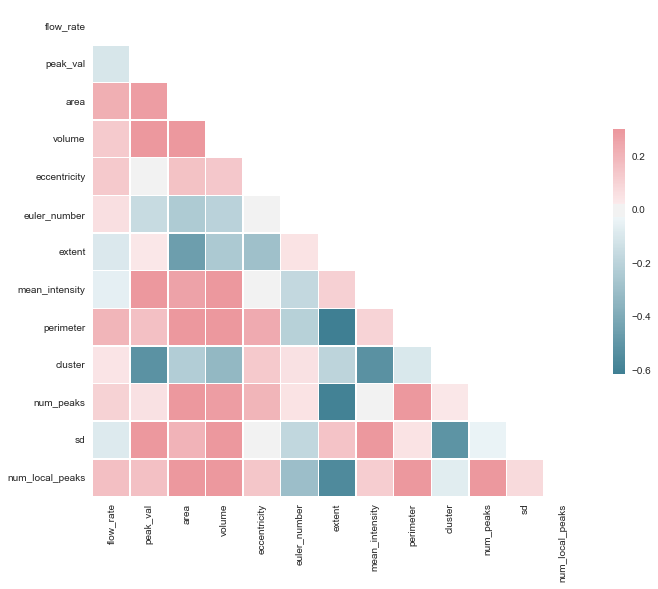

In [20]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_raw,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
data.groupby(['flow_rate','date']).mean().rank()

peak_val  area  volume  eccentricity  euler_number  \
flow_rate date                                                             
1800      2017.11.09      11.0   3.0     5.0           5.0           1.0   
          2017.11.17       1.0   1.0     1.0           4.0           9.0   
          2017.11.22       9.0   4.0     3.0           9.0           9.0   
          2017.11.23       8.0   9.0     9.0           2.0           3.0   
3600      2017.11.09      10.0   8.0     6.0           1.0           9.0   
          2017.11.17       5.0   7.0    10.0           7.0           9.0   
          2017.11.22       6.0   6.0     4.0          10.0           2.0   
          2017.11.23       4.0   2.0     2.0           3.0           6.0   
7200      2017.11.17       2.0  10.0     8.0           8.0           5.0   
          2017.11.22       3.0   5.0     7.0           6.0           9.0   
          2017.11.23       7.0  11.0    11.0          11.0           4.0   

                      extent  mean_intensity  orientation  perimeter  cluster  \
flow_rate date                                                                  
1800      2017.11.09     8.0            11.0          3.0        6.0      3.0   
          2017.11.17    11.0             1.0         11.0        1.0     10.0   
          2017.11.22     3.0             8.0         10.0        4.0      8.0   
          2017.11.23     9.0            10.0          5.0        8.0      2.0   
3600      2017.11.09     1.0             3.0          6.0       11.0      4.0   
          2017.11.17     6.0             6.0          9.0        5.0      9.0   
          2017.11.22     2.0             4.0          4.0        7.0      1.0   
          2017.11.23    10.0             5.0          8.0        2.0      7.0   
7200      2017.11.17     7.0             2.0          2.0       10.0      6.0   
          2017.11.22     5.0             7.0          7.0        3.0     11.0   
          2017.11.23     4.0             9.0          1.0        9.0      5.0   

                      num_peaks    sd  num_local_peaks  
flow_rate date                                          
1800      2017.11.09        7.0  11.0              3.0  
          2017.11.17        1.0   1.0              1.0  
          2017.11.22        5.5   8.0              5.0  
          2017.11.23        5.5  10.0              8.0  
3600      2017.11.09       11.0   4.0             10.0  
          2017.11.17        4.0   6.0              6.0  
          2017.11.22        9.0   3.0              7.0  
          2017.11.23        2.0   7.0              2.0  
7200      2017.11.17        8.0   2.0             11.0  
          2017.11.22        3.0   5.0              4.0  
          2017.11.23       10.0   9.0              9.0

In [22]:
data.groupby(['date','flow_rate']).count()

name  source  peak_val  area  volume  eccentricity  \
date       flow_rate                                                       
2017.11.09 1800         11      11        11    11      11            11   
           3600         11      11        11    11      11            11   
2017.11.17 1800         10      10        10    10      10            10   
           3600         19      19        19    19      19            19   
           7200         25      25        25    25      25            25   
2017.11.22 1800         18      18        18    18      18            18   
           3600         17      17        17    17      17            17   
           7200         17      17        17    17      17            17   
2017.11.23 1800         27      27        27    27      27            27   
           3600         30      30        30    30      30            30   
           7200         16      16        16    16      16            16   

                      euler_number  extent  mean_intensity  moments  \
date       flow_rate                                                  
2017.11.09 1800                 11      11              11       11   
           3600                 11      11              11       11   
2017.11.17 1800                 10      10              10       10   
           3600                 19      19              19       19   
           7200                 25      25              25       25   
2017.11.22 1800                 18      18              18       18   
           3600                 17      17              17       17   
           7200                 17      17              17       17   
2017.11.23 1800                 27      27              27       27   
           3600                 30      30              30       30   
           7200                 16      16              16       16   

                      orientation  perimeter  inertia_tensor  cluster  \
date       flow_rate                                                    
2017.11.09 1800                11         11              11       11   
           3600                11         11              11       11   
2017.11.17 1800                10         10              10       10   
           3600                19         19              19       19   
           7200                25         25              25       25   
2017.11.22 1800                18         18              18       18   
           3600                17         17              17       17   
           7200                17         17              17       17   
2017.11.23 1800                27         27              27       27   
           3600                30         30              30       30   
           7200                16         16              16       16   

                      num_peaks  sd  num_local_peaks  
date       flow_rate                                  
2017.11.09 1800              11  11               11  
           3600              11  11               11  
2017.11.17 1800              10  10               10  
           3600              19  19               19  
           7200              25  25               25  
2017.11.22 1800              18  18               18  
           3600              17  17               17  
           7200              17  17               17  
2017.11.23 1800              27  27               27  
           3600              30  30               30  
           7200              16  16               16

In [23]:
data.groupby('date').mean().drop(columns=['flow_rate']).rank()

,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,orientation,perimeter,cluster,num_peaks,sd,num_local_peaks
date,,,,,,,,,,,,,
2017.11.09,4.0,2.0,2.0,1.0,1.0,2.0,4.0,1.0,4.0,1.0,4.0,4.0,4.0
2017.11.17,1.0,4.0,3.0,3.0,4.0,3.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0
2017.11.22,3.0,1.0,1.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,2.0,2.0,1.0
2017.11.23,2.0,3.0,4.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0


In [24]:
samples_ranked_mean = data.groupby('date').mean().drop(columns=['flow_rate']).rank()
samples_ranked_sum = data.groupby('date').sum().drop(columns=['flow_rate']).rank()

In [25]:
samples_ranked = samples_ranked_mean
samples_ranked['count'] = data.groupby(['date']).count().rank()['area'].reshape(4)

samples_merged = []
samples_merged.append([samples_ranked['peak_val']])

for column in samples_ranked:
    found_match = False
    for merged in samples_merged:
        merged_s = merged[0]
                
        if merged_s.equals(samples_ranked[column]):
            merged.append(samples_ranked[column])
            found_match = True
            break
    
    if not found_match:
        samples_merged.append([samples_ranked[column]])

print(len(samples_merged))
        
for sm in samples_merged:
    sample = sm[0]
    print(sample.values)

9
[4. 1. 3. 2.]
[2. 4. 1. 3.]
[2. 3. 1. 4.]
[1. 3. 4. 2.]
[1. 4. 3. 2.]
[4. 1. 2. 3.]
[4. 3. 1. 2.]
[4. 3. 2. 1.]
[1. 3. 2. 4.]


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [26]:
kendall_table = []
p_table = []

perfect_matches = []

for marker in biomarkers_ranked:
    marker_list = []
    p_list = []
    
    for feature in samples_ranked:
        tau, p_value = kt(biomarkers_ranked[marker],samples_ranked[feature])
        marker_list.append(tau)
        p_list.append(p_value)
        
        if abs(tau) == 1:
            perfect_matches.append((marker, feature))
        
    kendall_table.append(marker_list)
    p_table.append(p_list)

kendall_df = pd.DataFrame.from_records(kendall_table,columns=list(samples_ranked))
kendall_df['biomarker'] = list(biomarkers_ranked)
kendall_df = kendall_df.set_index('biomarker')

p_table = pd.DataFrame.from_records(p_table,columns=list(samples_ranked))
p_table['biomarker'] = list(biomarkers_ranked)
p_table = p_table.set_index('biomarker')

In [27]:
print(perfect_matches)

[('FSC-A Median', 'peak_val'), ('CD9 Geomean', 'perimeter'), ('CD9 Geomean', 'num_local_peaks'), ('RCA - FITC Geomean', 'perimeter'), ('RCA - FITC Geomean', 'num_local_peaks'), ('WBC x10^9/L', 'eccentricity'), ('WBC x10^9/L', 'orientation'), ('Neu %', 'num_peaks'), ('RBC x10^12/L', 'perimeter'), ('RBC x10^12/L', 'num_local_peaks'), ('HGB g/L', 'perimeter'), ('HGB g/L', 'num_local_peaks'), ('HCT L/L', 'perimeter'), ('HCT L/L', 'num_local_peaks'), ('MCV fL', 'area'), ('MCH pg', 'perimeter'), ('MCH pg', 'num_local_peaks'), ('MCHC g/L', 'area'), ('PLT x10^9/L', 'perimeter'), ('PLT x10^9/L', 'num_local_peaks'), ('PLT PRP count 10^9/L', 'area'), ('MPV PRP fL', 'count')]


In [28]:
kendall_df.shape

(31, 14)

In [29]:
kendall_df.head()

,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,orientation,perimeter,cluster,num_peaks,sd,num_local_peaks,count
biomarker,,,,,,,,,,,,,,
FSC-A Median,-1.000000,0.666667,0.333333,0.333333,0.666667,0.333333,-0.666667,0.333333,0.000000,0.666667,-0.333333,-0.666667,0.000000,0.666667
SCC-A Median,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,-0.333333,0.000000,0.333333,0.333333,0.666667,-0.333333,0.333333,-0.333333
GPVI Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAM10 Geomean,-0.333333,0.000000,-0.333333,0.333333,0.666667,-0.333333,-0.666667,0.333333,0.000000,0.666667,0.333333,-0.666667,0.000000,0.000000
AK2 Geomean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


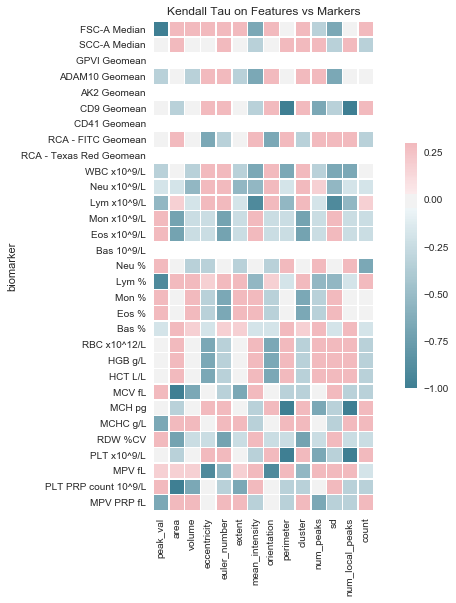

In [30]:
# Generate a mask for the upper triangle
mask = np.zeros_like(kendall_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title('Kendall Tau on Features vs Markers')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(kendall_df, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

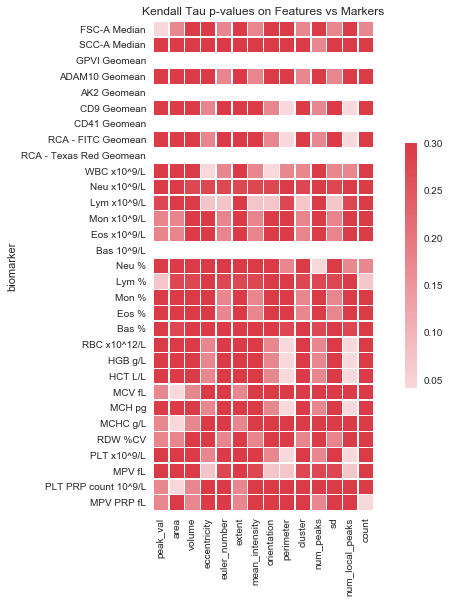

In [31]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
plt.title('Kendall Tau p-values on Features vs Markers')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(p_table, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## t-Test

In [32]:
t_list = []
p_table = []

for marker in samples:
    marker_list = []
    p_list = []
    for feature in samples:
        t_score, p_value = tt(samples[marker],samples[feature])
        marker_list.append(t_score)
        p_list.append(p_value)
        
    t_list.append(marker_list)
    p_table.append(p_list)

t_score_table = pd.DataFrame.from_records(t_list,columns=list(samples))
t_score_table['feature'] = list(samples)
t_score_table = t_score_table.set_index('feature')

p_table = pd.DataFrame.from_records(p_table,columns=list(samples))
p_table['feature'] = list(samples)
p_table = p_table.set_index('feature')

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


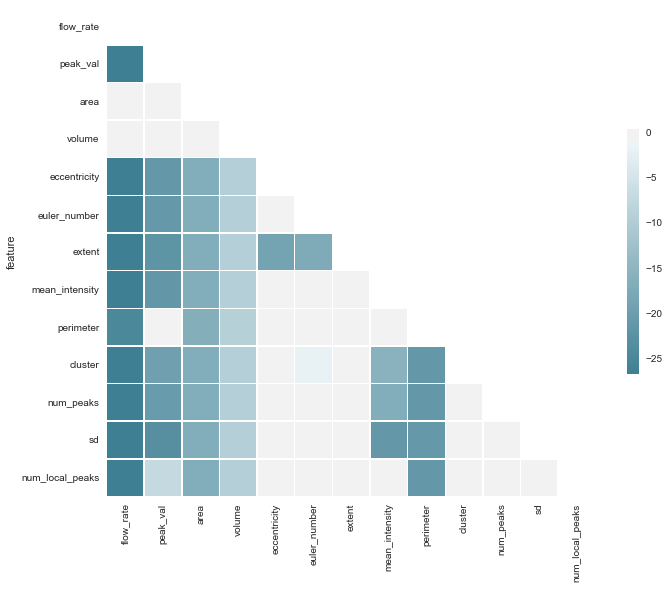

In [33]:
# Generate a mask for the upper triangle
mask = np.zeros_like(t_score_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(t_score_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

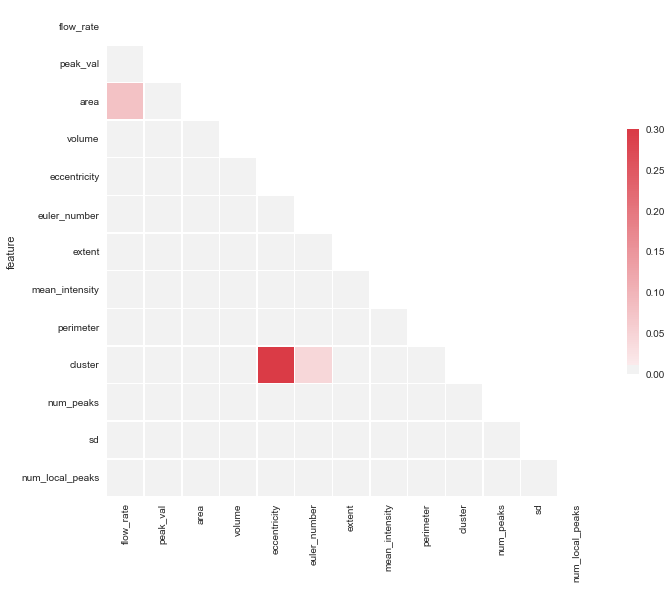

In [34]:
# Generate a mask for the upper triangle
mask = np.zeros_like(p_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(p_table, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Graphs

In [35]:
donor_count = donor.value_counts()

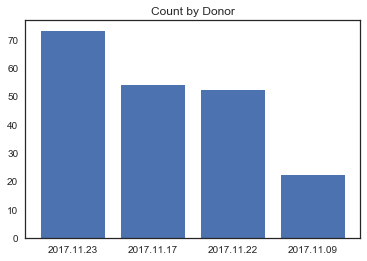

In [36]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

#plt.subplot(121)
#plt.title("Count by Cluster")
#plt.hist(donor_count.values, bins=4)

#fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)

x = np.arange(4)
#plt.subplot(121)
plt.title("Count by Donor")
plt.bar(x, donor_count.values)
plt.xticks(x, donor_count.index)
plt.show()

plt.show()

Number of different blobs as identified by Otsu's

Num Peaks by Donor: 
2017.11.23: 1    65
2     7
3     1
Name: num_peaks, dtype: int64
2017.11.17: 1    46
2     7
3     1
Name: num_peaks, dtype: int64
2017.11.22: 1    44
2     8
Name: num_peaks, dtype: int64
2017.11.09: 1    17
2     3
3     2
Name: num_peaks, dtype: int64
Num Peaks by Flow Rate: 
1800: [59, 7, 0]
3600: [66, 9, 2]
7200: [47, 9, 2]


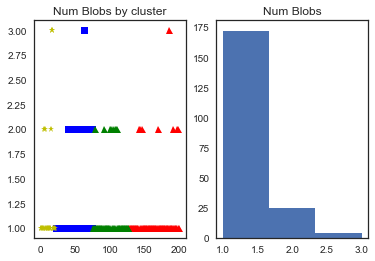

In [37]:
t = data[data['date']=='2017.11.23']['num_peaks']
u = data[data['date']=='2017.11.17']['num_peaks']
v = data[data['date']=='2017.11.22']['num_peaks']
w = data[data['date']=='2017.11.09']['num_peaks']

print("Num Peaks by Donor: ")
print("2017.11.23: " + str(t.value_counts()))
print("2017.11.17: " + str(u.value_counts()))
print("2017.11.22: " + str(v.value_counts()))
print("2017.11.09: " + str(w.value_counts()))

N = 4

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

Peak Value of each image

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


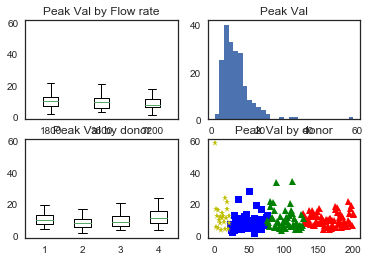

In [38]:
t = data[data['date']=='2017.11.23']['peak_val']
u = data[data['date']=='2017.11.17']['peak_val']
v = data[data['date']=='2017.11.22']['peak_val']
w = data[data['date']=='2017.11.09']['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Peak Val by donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


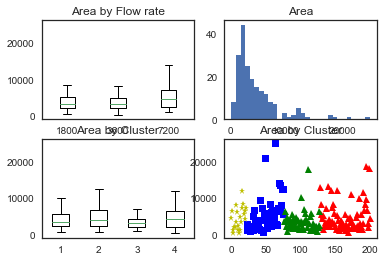

In [39]:
t = data[data['date']=='2017.11.23']['area']
u = data[data['date']=='2017.11.17']['area']
v = data[data['date']=='2017.11.22']['area']
w = data[data['date']=='2017.11.09']['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Area by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


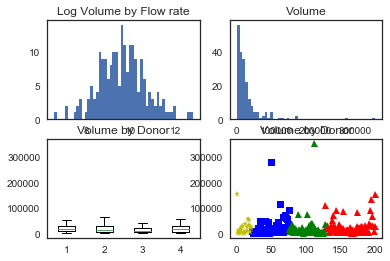

In [40]:
t = data[data['date']=='2017.11.23']['volume']
u = data[data['date']=='2017.11.17']['volume']
v = data[data['date']=='2017.11.22']['volume']
w = data[data['date']=='2017.11.09']['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Log Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Volume by Donor")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


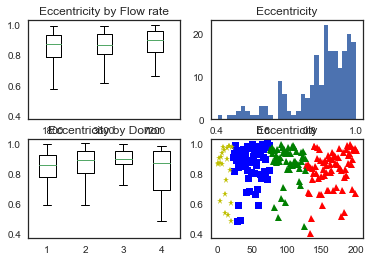

In [41]:
t = data[data['date']=='2017.11.23']['eccentricity']
u = data[data['date']=='2017.11.17']['eccentricity']
v = data[data['date']=='2017.11.22']['eccentricity']
w = data[data['date']=='2017.11.09']['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')


plt.show()

Euler characteristic of region. Computed as number of objects (= 1) subtracted by number of holes (8-connectivity).

Euler Number by Flow Rate: 
1800: [2, 3, 61]
3600: [4, 73]
7200: [3, 55]


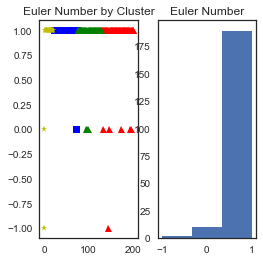

In [42]:
t = data[data['date']=='2017.11.23']['euler_number']
u = data[data['date']=='2017.11.17']['euler_number']
v = data[data['date']=='2017.11.22']['euler_number']
w = data[data['date']=='2017.11.09']['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


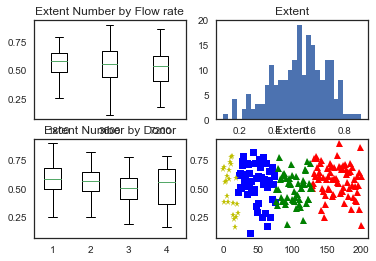

In [43]:
t = data[data['date']=='2017.11.23']['extent']
u = data[data['date']=='2017.11.17']['extent']
v = data[data['date']=='2017.11.22']['extent']
w = data[data['date']=='2017.11.09']['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Donor")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


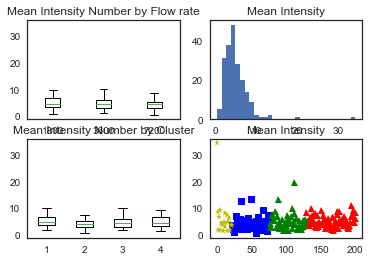

In [44]:
t = data[data['date']=='2017.11.23']['mean_intensity']
u = data[data['date']=='2017.11.17']['mean_intensity']
v = data[data['date']=='2017.11.22']['mean_intensity']
w = data[data['date']=='2017.11.09']['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

Angle between the X-axis and the major axis of the ellipse that has the same second-moments as the region. Ranging from -pi/2 to pi/2 in counter-clockwise direction.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


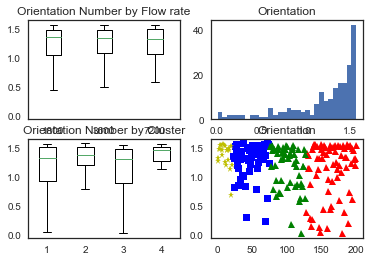

In [45]:
t = pd.DataFrame.abs(data[data['date']=='2017.11.23']['orientation'])
u = pd.DataFrame.abs(data[data['date']=='2017.11.17']['orientation'])
v = pd.DataFrame.abs(data[data['date']=='2017.11.22']['orientation'])
w = pd.DataFrame.abs(data[data['date']=='2017.11.09']['orientation'])

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


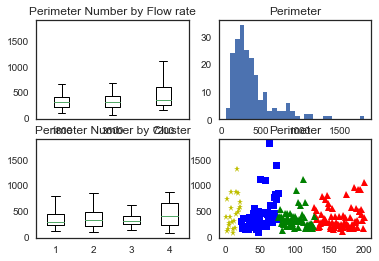

In [46]:
t = data[data['date']=='2017.11.23']['perimeter']
u = data[data['date']=='2017.11.17']['perimeter']
v = data[data['date']=='2017.11.22']['perimeter']
w = data[data['date']=='2017.11.09']['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


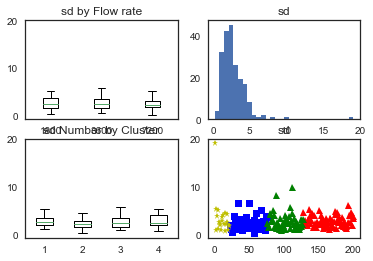

In [47]:
t = data[data['date']=='2017.11.23']['sd']
u = data[data['date']=='2017.11.17']['sd']
v = data[data['date']=='2017.11.22']['sd']
w = data[data['date']=='2017.11.09']['sd']

a = data[data['flow_rate']==1800]['sd']
b = data[data['flow_rate']==3600]['sd']
c = data[data['flow_rate']==7200]['sd']

plt.subplot(221)
plt.title("sd by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("sd")
plt.hist(data['sd'], bins=30)

plt.subplot(223)
plt.title("sd Number by Cluster")
plt.boxplot([t,u,v,w], labels=['1','2','3','4'])

plt.subplot(224)
plt.title("sd")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.show()

num_local_peaks by Donor: 
2017.11.23: 3     11
4     11
5      9
1      8
2      7
7      6
8      3
13     3
9      3
16     2
6      2
22     1
20     1
11     1
12     1
14     1
15     1
18     1
10     1
Name: num_local_peaks, dtype: int64
2017.11.17: 2     8
1     7
8     6
4     6
3     6
5     4
10    3
21    2
14    2
12    2
11    2
9     2
31    1
27    1
17    1
6     1
Name: num_local_peaks, dtype: int64
2017.11.22: 4     12
2      7
7      6
5      5
3      5
6      3
1      3
11     2
10     2
9      2
8      2
28     1
19     1
14     1
Name: num_local_peaks, dtype: int64
2017.11.09: 9     3
2     3
11    2
6     2
0     2
21    1
16    1
13    1
12    1
10    1
7     1
5     1
4     1
3     1
1     1
Name: num_local_peaks, dtype: int64
Num Peaks by Flow Rate: 
1800: [2, 4, 11, 10, 7, 6, 2, 6, 4, 4, 1, 2, 3, 2, 1, 1, 0]
3600: [10, 9, 8, 11, 9, 2, 4, 6, 3, 5, 4, 1, 1, 1, 1, 2]
7200: [5, 5, 5, 12, 4, 4, 3, 1, 3, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 1]


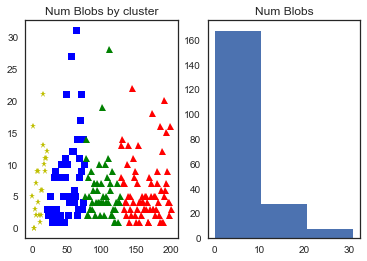

In [48]:
t = data[data['date']=='2017.11.23']['num_local_peaks']
u = data[data['date']=='2017.11.17']['num_local_peaks']
v = data[data['date']=='2017.11.22']['num_local_peaks']
w = data[data['date']=='2017.11.09']['num_local_peaks']

print("num_local_peaks by Donor: ")
print("2017.11.23: " + str(t.value_counts()))
print("2017.11.17: " + str(u.value_counts()))
print("2017.11.22: " + str(v.value_counts()))
print("2017.11.09: " + str(w.value_counts()))

N = 4

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_local_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_local_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_local_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^', w, 'y*')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_local_peaks'], bins=3)

plt.show()

## Mutual Information

In [49]:
print(feature_selection.mutual_info_classif(samples.as_matrix(), data['date']))
print(list(train_data.head()))

[0.10506875 0.00548075 0.         0.09380514 0.         0.
 0.0134955  0.         0.         0.0352005  0.02803319 0.03288134
 0.        ]
['peak_val', 'area', 'volume', 'eccentricity', 'euler_number', 'extent', 'mean_intensity', 'perimeter', 'cluster', 'num_peaks', 'sd', 'num_local_peaks']


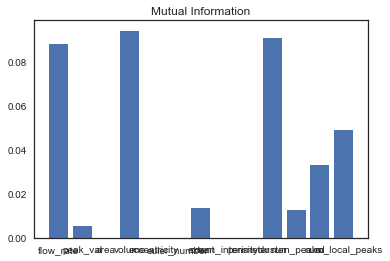

In [50]:
mi = feature_selection.mutual_info_classif(samples.as_matrix(), data['date'])
labels = list(samples.head())

x = np.arange(len(mi))

fig, ax = plt.subplots()
plt.title("Mutual Information")
plt.bar(x, mi)
plt.xticks(x, labels)

plt.show()

In [51]:
pd.DataFrame(data=biomarker_values,columns=list(biomarker_values)).corr()

,FSC-A Median,SCC-A Median,GPVI Geomean,ADAM10 Geomean,AK2 Geomean,CD9 Geomean,CD41 Geomean,RCA - FITC Geomean,RCA - Texas Red Geomean,WBC x10^9/L,...,HGB g/L,HCT L/L,MCV fL,MCH pg,MCHC g/L,RDW %CV,PLT x10^9/L,MPV fL,PLT PRP count 10^9/L,MPV PRP fL
FSC-A Median,1.000000,0.686195,-0.301501,0.423011,0.999899,-0.412857,-0.976012,0.398830,-0.972705,0.487859,...,-0.098783,-0.189506,-0.822514,-0.264512,0.880590,-0.980350,0.375372,-0.114520,-0.608710,5.287312e-01
SCC-A Median,0.686195,1.000000,0.419771,0.560508,0.983204,-0.835612,-0.998744,0.929797,-0.919682,0.093068,...,0.606286,0.544604,-0.595133,-0.737976,0.496879,-0.812001,-0.365300,0.465607,-0.402516,-1.256624e-01
GPVI Geomean,-0.301501,0.419771,1.000000,-0.900727,1.000000,-0.759878,-1.000000,0.775896,-1.000000,-0.984245,...,0.990744,0.999496,-0.132965,-0.848791,-0.103109,0.188544,-0.989227,0.982065,-0.322342,-4.996136e-01
ADAM10 Geomean,0.423011,0.560508,-0.900727,1.000000,0.443666,-0.040977,-0.639117,0.367117,-0.237408,0.750062,...,0.002732,-0.002043,0.105124,0.089221,-0.054498,-0.525012,0.133882,-0.310705,0.405745,-4.548638e-01
AK2 Geomean,0.999899,0.983204,1.000000,0.443666,1.000000,-0.930145,-0.972825,0.997972,-0.975900,0.223001,...,0.943933,0.952052,-0.834180,-0.862818,0.851674,-0.994111,-0.645251,0.590905,-0.625766,2.942848e-01
CD9 Geomean,-0.412857,-0.835612,-0.759878,-0.040977,-0.930145,1.000000,0.819847,-0.932715,0.987857,0.456926,...,-0.845253,-0.788120,0.656964,0.985438,-0.477995,0.526290,0.673652,-0.849537,0.634435,3.043436e-02
CD41 Geomean,-0.976012,-0.998744,-1.000000,-0.639117,-0.972825,0.819847,1.000000,-0.985590,0.898852,-0.442653,...,-0.841840,-0.855342,0.683817,0.722322,-0.707184,0.992187,0.450824,-0.388052,0.428154,-6.499747e-02
RCA - FITC Geomean,0.398830,0.929797,0.775896,0.367117,0.997972,-0.932715,-0.985590,1.000000,-0.960032,-0.238633,...,0.856424,0.814284,-0.459949,-0.892627,0.292533,-0.555871,-0.681327,0.737214,-0.355123,-3.089698e-01
RCA - Texas Red Geomean,-0.972705,-0.919682,-1.000000,-0.237408,-0.975900,0.987857,0.898852,-0.960032,1.000000,-0.004903,...,-0.993226,-0.995868,0.934422,0.952337,-0.945511,0.946505,0.796413,-0.752710,0.780897,-4.957478e-01
WBC x10^9/L,0.487859,0.093068,-0.984245,0.750062,0.223001,0.456926,-0.442653,-0.238633,-0.004903,1.000000,...,-0.648854,-0.660840,0.070595,0.599145,0.115163,-0.452911,0.754027,-0.832050,0.336317,6.201737e-02


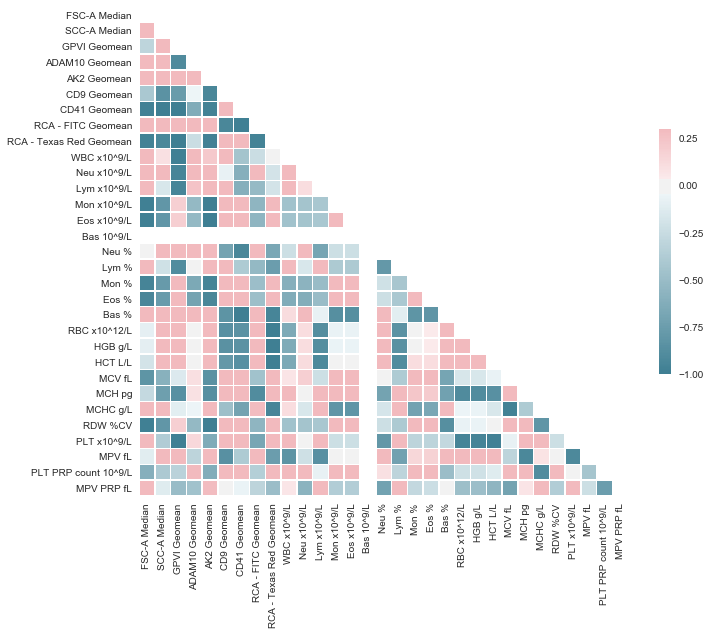

In [52]:
# Compute the correlation matrix
corr = pd.DataFrame(data=biomarker_values,columns=list(biomarker_values)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Cluster sizes

### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

standard: 0.062 sec
ltsa: 0.1 sec
hessian: 0.15 sec
modified: 0.13 sec
Isomap: 0.057 sec
MDS: 0.099 sec
SpectralEmbedding: 0.014 sec
t-SNE: 3.7 sec


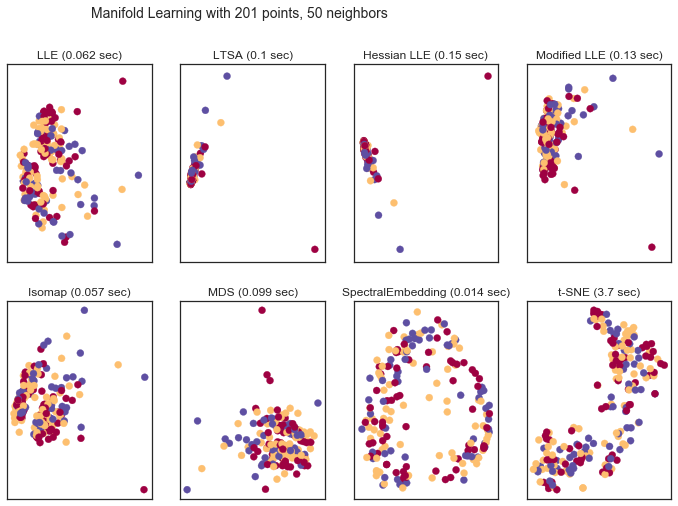

In [53]:
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = standardize
color = data['flow_rate']

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

t-SNE: 8.5 sec
t-SNE: 7.9 sec
t-SNE: 3.9 sec
t-SNE: 6.7 sec
t-SNE: 4.2 sec


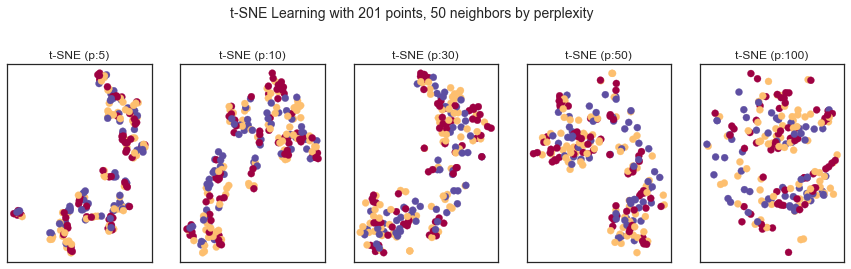

In [54]:
perplexity = [5,10,30,50,100]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("t-SNE Learning with %i points, %i neighbors by perplexity"
             % (len(points), n_neighbors), fontsize=14)

for i,p in enumerate(perplexity):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, perplexity=p, init='pca',n_iter=5000, random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(251+i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (p:%d)" % (p))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

plt.show()